<a href="https://colab.research.google.com/github/andryll/MGR-IC/blob/main/codes/ClassificationTestes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
# Importando as Bibliotecas

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn import neighbors
from sklearn import tree
from sklearn import ensemble
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from sklearn.metrics import balanced_accuracy_score
import random
from collections import Counter

### Algoritmos

In [2]:
def KFoldCrossValidation(dataframe, n_splits, seed):

    X_columns = dataframe.columns[dataframe.columns != 'Classe']
    X = dataframe[X_columns]
    Y = dataframe['Classe']

    skf = StratifiedKFold(n_splits = n_splits, shuffle=True, random_state = seed)

    X_train_list = []
    X_test_list = []
    Y_train_list = []
    Y_test_list = []

    for train_index, test_index in skf.split(X, Y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]

        # Armazenar os vetores de treino e teste nas listas
        X_train_list.append(X_train.values.tolist())
        X_test_list.append(X_test.values.tolist())
        Y_train_list.append(Y_train.to_list())
        Y_test_list.append(Y_test.to_list())

    return X_train_list, X_test_list, Y_train_list, Y_test_list

In [3]:
def BlockSplit(dataframe, n_splits, seed, n_songs):

  random.seed(seed)
  n_block = round(dataframe.shape[0] / n_songs)
  songs_per_genre = round(n_songs/10)
  n_test = round(songs_per_genre * 0.1)

  test_list = []
  definitive_test_list = []


  for i in range(10):
    r = random.sample(range(i*songs_per_genre, (i+1)*songs_per_genre), n_test)
    for j in r:
      test_list.append(j)

  test_list.sort()
  for i in test_list:
    for j in range(n_block):
      definitive_test_list.append(round((i*n_block)+j))

  return definitive_test_list

In [53]:
def blockBalancedScore(Y_real, Y_predict, n_songs):

  #print(type(Y_real))

  n_samples = len(Y_predict)
  samples_per_song = (n_samples*10)/n_songs

  block_predict = []
  block_true = []

  # print('N_songs:', n_songs)
  # print('N_samples:', len(Y_predict))
  # print('samples_per_song:', samples_per_song)

  predict_groups = [Y_predict[i:i+int(samples_per_song)] for i in range(0, n_samples, int(samples_per_song))]

  for group in predict_groups:
    count = Counter(group)
    block_predict.append(count.most_common(1)[0][0])

  indexes = range(0, n_samples, int(samples_per_song))
  block_true = Y_real.iloc[indexes].tolist()

  return balanced_accuracy_score(block_true, block_predict)

In [4]:
def elbowKNN(dflist, n_neigh, seed, n_songs):


  scorelist = []

  for df in dflist:
    neigh = neighbors.KNeighborsClassifier(n_neighbors= n_neigh)

    test = BlockSplit(df, n_splits = 10, seed = seed, n_songs=n_songs)

    target = 'Classe'
    X_columns = df.columns[df.columns != target]
    X = df[X_columns]
    Y = df[target]

    neigh.fit(X.iloc[~X.index.isin(test),:], Y.iloc[~Y.index.isin(test)])
    Y_predict = neigh.predict(X.iloc[X.index.isin(test),:])

    scorelist.append(balanced_accuracy_score(Y.iloc[test], Y_predict))

  return scorelist

In [5]:
def elbowTree(dflist, seed, n_songs):

  scorelist = []

  for df in dflist:
    clf = tree.DecisionTreeClassifier(random_state = seed)

    test = BlockSplit(df, n_splits = 10, seed = seed, n_songs=n_songs)

    target = 'Classe'
    X_columns = df.columns[df.columns != target]
    X = df[X_columns]
    Y = df[target]

    clf.fit(X.iloc[~X.index.isin(test),:], Y.iloc[~Y.index.isin(test)])
    Y_predict = clf.predict(X.iloc[X.index.isin(test),:])

    scorelist.append(balanced_accuracy_score(Y.iloc[test], Y_predict))

  return scorelist

In [6]:
def elbowRF(dflist, seed, n_songs):

  scorelist = []

  for df in dflist:
    rf = ensemble.RandomForestClassifier(random_state = seed)

    test = BlockSplit(df, n_splits = 10, seed = seed, n_songs=n_songs)

    target = 'Classe'
    X_columns = df.columns[df.columns != target]
    X = df[X_columns]
    Y = df[target]

    rf.fit(X.iloc[~X.index.isin(test),:], Y.iloc[~Y.index.isin(test)])
    Y_predict = rf.predict(X.iloc[X.index.isin(test),:])

    scorelist.append(balanced_accuracy_score(Y.iloc[test], Y_predict))

  return scorelist

In [21]:
def elbowAll(dflist, seed, n_songs, block_score = True):
  scorelistKNN3 = []
  scorelistKNN5 = []
  scorelistKNN7 = []
  scorelistDT = []
  scorelistRF = []

  for df in dflist:
    neigh3 = neighbors.KNeighborsClassifier(n_neighbors= 3)
    neigh5 = neighbors.KNeighborsClassifier(n_neighbors= 5)
    neigh7 = neighbors.KNeighborsClassifier(n_neighbors= 7)
    clf = tree.DecisionTreeClassifier(random_state = seed)
    rf = ensemble.RandomForestClassifier(random_state = seed)

    test = BlockSplit(df, n_splits = 10, seed = seed, n_songs=n_songs)

    target = 'Classe'
    X_columns = df.columns[df.columns != target]
    X = df[X_columns]
    Y = df[target]

    neigh3.fit(X.iloc[~X.index.isin(test),:], Y.iloc[~Y.index.isin(test)])
    Y_predict3 = neigh3.predict(X.iloc[X.index.isin(test),:])

    neigh5.fit(X.iloc[~X.index.isin(test),:], Y.iloc[~Y.index.isin(test)])
    Y_predict5 = neigh5.predict(X.iloc[X.index.isin(test),:])

    neigh7.fit(X.iloc[~X.index.isin(test),:], Y.iloc[~Y.index.isin(test)])
    Y_predict7 = neigh7.predict(X.iloc[X.index.isin(test),:])

    clf.fit(X.iloc[~X.index.isin(test),:], Y.iloc[~Y.index.isin(test)])
    Y_predictDT = clf.predict(X.iloc[X.index.isin(test),:])

    rf.fit(X.iloc[~X.index.isin(test),:], Y.iloc[~Y.index.isin(test)])
    Y_predictRF = rf.predict(X.iloc[X.index.isin(test),:])

    if block_score == False:
      scorelistKNN3.append(balanced_accuracy_score(Y.iloc[test], Y_predict3))
      scorelistKNN5.append(balanced_accuracy_score(Y.iloc[test], Y_predict5))
      scorelistKNN7.append(balanced_accuracy_score(Y.iloc[test], Y_predict7))
      scorelistDT.append(balanced_accuracy_score(Y.iloc[test], Y_predictDT))
      scorelistRF.append(balanced_accuracy_score(Y.iloc[test], Y_predictRF))
    else:
      scorelistKNN3.append(blockBalancedScore(Y.iloc[test], Y_predict3, n_songs))
      scorelistKNN5.append(blockBalancedScore(Y.iloc[test], Y_predict5, n_songs))
      scorelistKNN7.append(blockBalancedScore(Y.iloc[test], Y_predict7, n_songs))
      scorelistDT.append(blockBalancedScore(Y.iloc[test], Y_predictDT, n_songs))
      scorelistRF.append(blockBalancedScore(Y.iloc[test], Y_predictRF, n_songs))

  return scorelistKNN3, scorelistKNN5, scorelistKNN7, scorelistDT, scorelistRF

### Testes

In [64]:
#Ler CSVs
dflist = []

csvnames = ['3s_512.csv','3s_1024.csv','3s_2048.csv','3s_4096.csv','3s8192.csv']

for i in csvnames:
  dir_path = os.path.join('F:/Documentos/UTFPR/IC/csvs/3s', i)
  dflist.append(pd.read_csv(dir_path, sep=',', encoding='utf-8'))


In [65]:
# Executa os algoritmos com as features desejadas e salva os valores de score nas listas

knnscores3 = []
knnscores5 = []
knnscores7 = []
dtscores = []
rfscores = []
seeds = [14, 42, 60, 87, 113, 156, 211, 456, 917, 1001]
# seeds = [14, 42, 60]


# for seed in seeds:
#   knnscores3.append(elbowKNN(dflist, n_neigh = 3, seed = seed, n_songs=500))
#   knnscores5.append(elbowKNN(dflist, n_neigh = 5, seed = seed, n_songs=500))
#   knnscores7.append(elbowKNN(dflist, n_neigh = 7, seed = seed, n_songs=500))

#   dtscores.append(elbowTree(dflist, seed = seed, n_songs=500))
#   rfscores.append(elbowRF(dflist, seed = seed, n_songs=500))

for seed in seeds:
  knn3, knn5, knn7, dt, rf = elbowAll(dflist, seed = seed, n_songs=500, block_score=True)

  knnscores3.append(knn3)
  knnscores5.append(knn5)
  knnscores7.append(knn7)
  dtscores.append(dt)
  rfscores.append(rf)

In [66]:
# Coloca as listas de score em uma outra lista a cria listas com as médias e os sds.

scoreslist = []
scoresmeans = []
scoressds = []

scoreslist.append(np.array(knnscores3))
scoreslist.append(np.array(knnscores5))
scoreslist.append(np.array(knnscores7))
scoreslist.append(np.array(dtscores))
scoreslist.append(np.array(rfscores))

# KNN3 = 0 / KNN5 = 1 / KNN7 = 2 / DT = 3 / RF = 4

for score in scoreslist:
  scoresmeans.append(np.mean(score, axis=0))
  scoressds.append(np.std(score, axis=0))

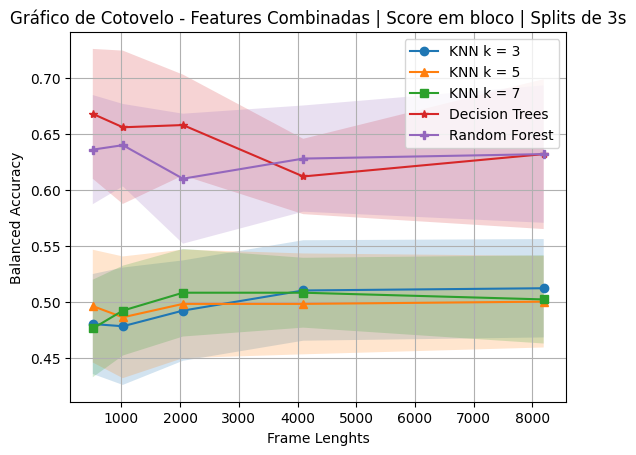

In [67]:
#  Plota o gráfico com as médias das seeds e os desvios padrão

frame_lenghts = [512, 1024, 2048, 4096, 8192]
labels = ['KNN k = 3', 'KNN k = 5', 'KNN k = 7', 'Decision Trees', 'Random Forest']
markers = ['o', '^', 's', '*', 'P']

for i in range(len(scoresmeans)):
  plt.plot(frame_lenghts, scoresmeans[i], label = labels[i], marker = markers[i])
  plt.fill_between(frame_lenghts, scoresmeans[i] + scoressds[i], scoresmeans[i] - scoressds[i], alpha = 0.2)

plt.legend()
plt.grid()
plt.ylabel('Balanced Accuracy')
plt.xlabel('Frame Lenghts')
plt.title('Gráfico de Cotovelo - Features Combinadas | Score em bloco | Splits de 3s')

# Nome do arquivo pra salvar
plt.savefig('3s_block.pdf')
plt.show()

In [68]:
print(scoresmeans)

[array([0.48 , 0.478, 0.492, 0.51 , 0.512]), array([0.496, 0.486, 0.498, 0.498, 0.5  ]), array([0.476, 0.492, 0.508, 0.508, 0.502]), array([0.668, 0.656, 0.658, 0.612, 0.632]), array([0.636, 0.64 , 0.61 , 0.628, 0.632])]


### Testezao

In [ ]:
print(df.iloc[:,df.columns.get_loc('Classe')].shape)
print(len(all_rock))
dflist[0].shape

(5000,)
1


(5000, 2114)

In [ ]:
same_scores = []
random_scores = []

genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']

for df in dflist:
  all_rock = ['rock' for _ in range(df.shape[0])]
  all_random = [random.choice(genres) for _ in range(df.shape[0])]
  same_scores.append(balanced_accuracy_score(df.iloc[:,df.columns.get_loc('Classe')], all_rock))
  random_scores.append(balanced_accuracy_score(df.iloc[:,df.columns.get_loc('Classe')], all_random))

print(same_scores)
print(random_scores)


[0.1, 0.1, 0.1, 0.1, 0.1]
[0.1024, 0.09759999999999999, 0.1026, 0.0968, 0.1004]


In [ ]:
all_rock = ['rock']*dflist[0].shape[0]

In [18]:
Y_predict = [1,2,3,4,4,5,6,7,8,4,1,1,1,1,1,1,1,1,1,1,2,3,4,5,3,3,3,3,7,8]

Y_real = 0

blockBalancedScore(Y_predict, Y_real, 3)

[4, 1, 3]


In [12]:
len(Y_predict)

30